<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


### ***Name***: Garv Sharma
### ***username***: gs1023
### ***CID***: 02486336


You can save this notebook in Colab by clicking `File` from the top menu, and then selecting `Download --> Download .ipynb`

Make sure that when you save your notebook you have all the cells executed and you can see the outputs (livelossplot graphs, etc)

## Hyperparameter tunning notebook

Explain the steps and tests you do.

Organise it well to show how the data you present here has helped you design your final network hyperparameters (that you will use for the final training in the `yourusername_DLcw1_clean.ipynb` notebook).

**Step 1:** Loading Imports and training data

In [1]:
!pip install livelossplot
%pylab inline

from livelossplot import PlotLosses

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import optim

import random
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
# Define the location of the dataset
data_dir = '/content/gdrive/MyDrive/real_hands'

# Define the transformations for our images
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.Grayscale(),       # Convert to grayscale if not already
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the images
])

# Our CustomImageDataset will load the images and transform it to training dataset
class CustomImageDataset(Dataset):
    def __init__(self, path, transform):
        self.path = path
        self.files = os.listdir(path)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.path, img_name)
        with open(img_path, 'rb') as f:
            img = Image.open(f)
            img = img.convert('L')  # Convert to grayscale
        return self.transform(img)



In [4]:
# Instantiate the dataset
train_dataset = CustomImageDataset(data_dir, transform)

# Check the total number of images
print(f"Total number of images: {len(train_dataset)}")

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

# Fetch a batch of images
images_batch = next(iter(train_loader))
print(f"Image batch shape: {images_batch.size()}")

Total number of images: 8000
Image batch shape: torch.Size([100, 1, 28, 28])


Trying to plot the images loaded into train_loader above

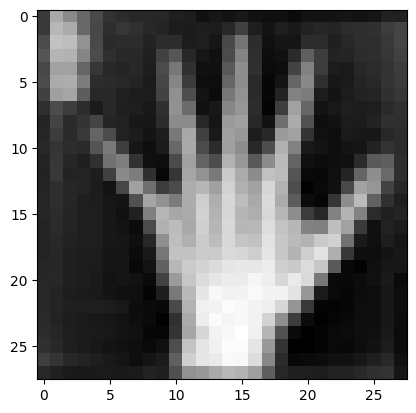

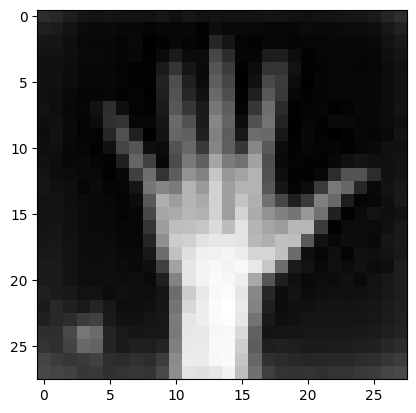

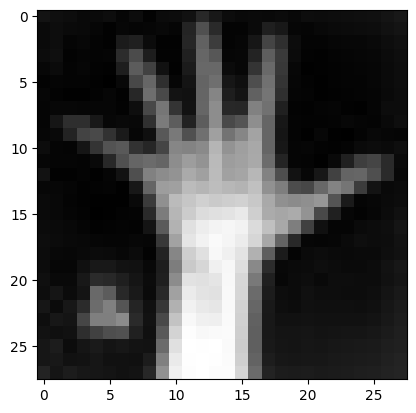

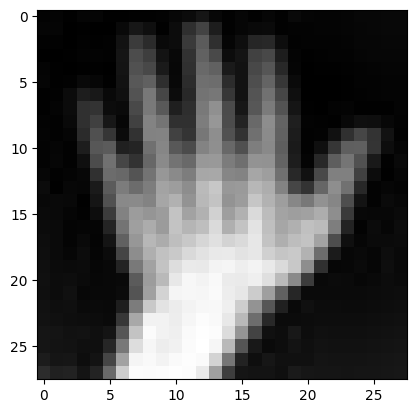

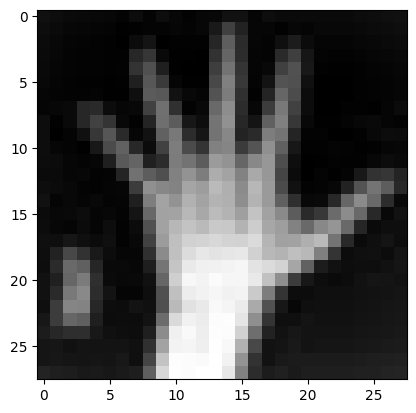

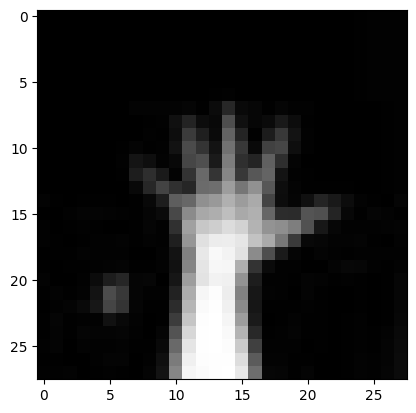

In [ ]:
import matplotlib.pyplot as plt

# Function to display an image
def show_image(img):
    # Handle case for single-channel and multi-channel images differently
    if img.shape[0] == 1:  # Grayscale image (1 channel)
        plt.imshow(img.squeeze(), cmap='gray')
    else:  # RGB image (3 channels)
        # Convert from PyTorch's channel-first format to channel-last format
        img = img.permute(1, 2, 0)
        plt.imshow(img)
    plt.show()

# Display the first image from the first 9 batches
for i, images in enumerate(train_loader):
    if i == 6:  # Stop after 9 images
        break
    show_image(images[0])  # Adjust [0] to select different images in the batch


Batch size: 100
Number of batches: 80
Num images: 8000

Image shape: torch.Size([100, 1, 28, 28])
Num pixels: 784
Range: max, 1.0 min,-1.0


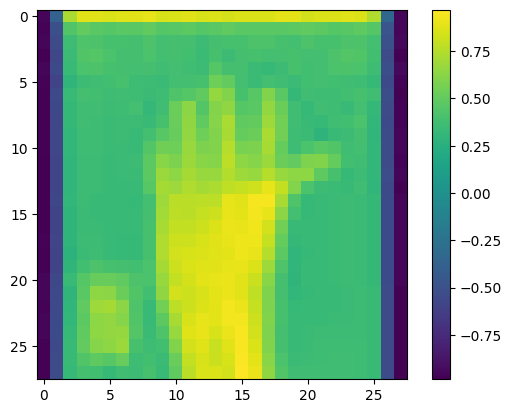

In [ ]:
# check the details
print(train_loader)
print('Batch size: '+str(train_loader.batch_size))
print('Number of batches: '+str(train_loader.__len__()))  # Check the number of batches
print('Num images: '+str(train_loader.batch_size*train_loader.__len__()))
print()

images = next(iter(train_loader))  # Get the first batch of images

print('Image shape: '+str(images.shape))

plt.imshow(images[0].squeeze())  # Plot the first image in the batch
plt.colorbar()

print('Num pixels: '+str(images.shape[2]*images.shape[3]))  # How many pixels are in the image
print('Range: max, '+str(float(images.max()))+' min,'+str(float(images.min())))


**Step 2:** Create a Generator and Distriminator model for GANs

We will start by creating a simple and linear generator and discriminator model

In [ ]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, g_input_dim=100, g_output_dim=28*28):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features * 2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features * 2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))
        return x


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim=28*28):
        super().__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [ ]:
# Instantiate the Generator and Discriminator models
G = Generator().to(device)
D = Discriminator().to(device)

# Print models summary (optional, for verification)
print(G)
print(D)

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)


**Step 3:** Train the generator and Discriminator model created above

In [ ]:
def D_train(x):
    #-------------- Function of the discriminator training -------------------#
    D.train()
    optimizerD.zero_grad()

    # train discriminator on real data -- assign high score (use 1 here)
    x_real, y_real = x.view(-1, 28*28), torch.ones(batch_size, 1)  # we are assigning the label 'real data' to the samples (don't care anymore about what number they are)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake data -- assign low score (use 0 here)
    # sample vector and produce generator output
    z = torch.randn(batch_size, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(batch_size, 1).to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)

    # combine the losses
    D_loss = D_real_loss + D_fake_loss

    # model update
    D_loss.backward()
    optimizerD.step()

    return  D_loss.data.item()  ### deprecated version of loss.detach(), basically gets access to the tensor without the computational graph attached

In [ ]:
def G_train(x):
    #-------------- Function of the generator training -------------------#
    G.train()
    optimizerG.zero_grad()

    # sample vector and produce generator output
    z = torch.randn(batch_size, z_dim).to(device)
    G_output = G(z)

    # obtain scores from D for the generated data
    D_output = D(G_output)

    # train generator to "fool" discriminator
    y = torch.ones(batch_size, 1).to(device)
    G_loss = criterion(D_output, y)

    # model update
    G_loss.backward()
    optimizerG.step()

    return G_loss.data.item()  ### deprecated version of loss.detach(), basically gets access to the tensor without the computational graph attached

**Step 4:** Using Hyperparameters and Plotting the liveloss

In [ ]:
import torch.optim as optim

# Hyperparameters Set 1
batch_size = 100
z_dim = 100  # Dimensionality of the latent space (noise vector)
lr = 0.0002  # Learning rate
n_epoch = 200

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(D.parameters(), lr=lr)
optimizerG = optim.Adam(G.parameters(), lr=lr)

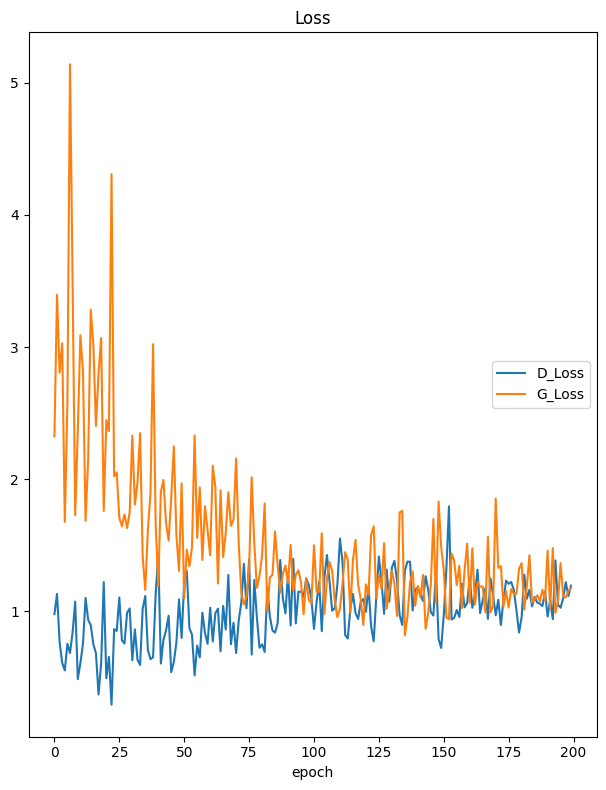

Loss
	D_Loss           	 (min:    0.295, max:    1.795, cur:    1.195)
	G_Loss           	 (min:    0.819, max:    5.139, cur:    1.181)


In [ ]:
# let's train our intial GAN and see how it performs

groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for i, x in enumerate(train_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

  # save every 20th epochs
  if(np.mod(epoch, 20) == 0):
    torch.save(G.state_dict(), "/content/gdrive/MyDrive/temp".format(epoch))

Text(0.5, 1.0, 'Epoch = 060')

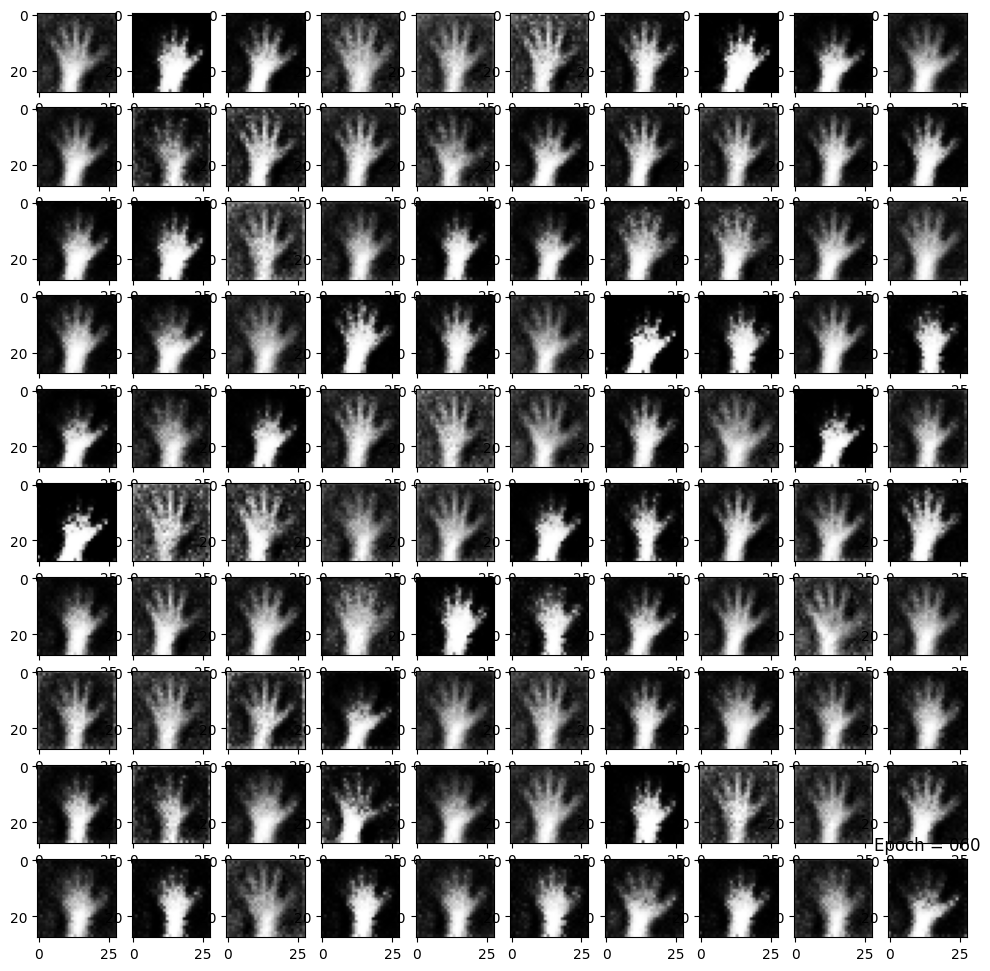

In [ ]:
# from torchvision.utils import save_image
set_seed(42)

epoch = 60  ## get the model after 20 epochs and use it:
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = torch.randn(batch_size, z_dim).to(device)
    generated = G(test_z)

    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 28, 28).cpu()):
  ax.imshow(img, cmap="gray")
plt.title('Epoch = {:03d}'.format(epoch))

Text(0.5, 1.0, 'Epoch = 200')

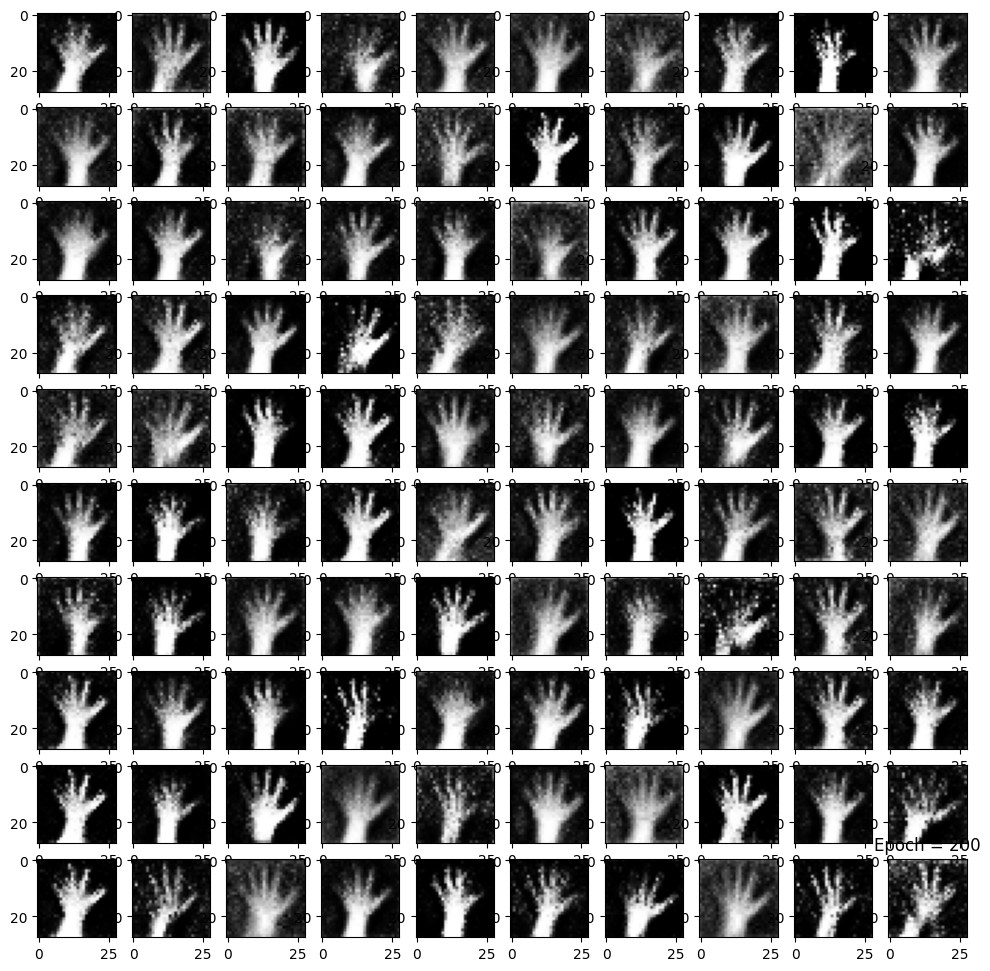

In [ ]:
# from torchvision.utils import save_image
set_seed(42)

epoch = 200  ## get the model after 20 epochs and use it:
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = torch.randn(batch_size, z_dim).to(device)
    generated = G(test_z)

    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 28, 28).cpu()):
  ax.imshow(img, cmap="gray")
plt.title('Epoch = {:03d}'.format(epoch))

Let's try WGAN and look at the results

In [38]:
class Generator(nn.Module):
    def __init__(self, g_input_dim=100, g_output_dim=28*28):
        super(Generator, self).__init__()
        # Increase the complexity of the model
        self.fc1 = nn.Linear(g_input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.bn3 = nn.BatchNorm1d(2048)
        self.fc4 = nn.Linear(2048, g_output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.fc2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.fc3(x)), 0.2)
        x = torch.tanh(self.fc4(x))
        return x


In [ ]:
class Critic(nn.Module):  # It's called Critic in WGAN
    def __init__(self, d_input_dim=28*28):
        super().__init__()
        self.fc1 = nn.Linear(d_input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return self.fc4(x)  # No sigmoid activation and no batchnorm

# Define the Wasserstein loss for the Critic
def wasserstein_loss(critic_scores_real, critic_scores_fake):
    return torch.mean(critic_scores_fake) - torch.mean(critic_scores_real)

# Example weight clipping function
def clip_weights(critic, clip_value):
    for p in critic.parameters():
        p.data.clamp_(-clip_value, clip_value)

In [ ]:
# WGAN Critic training function
def C_train(critic, generator, x_real, clip_value, optimizerC):
    critic.train()
    optimizerC.zero_grad()

    # Training the critic on real data
    x_real = x_real.view(-1, 28*28).to(device)
    critic_real = critic(x_real)
    critic_real_loss = -torch.mean(critic_real)

    # Training the critic on fake data generated by the generator
    z = torch.randn(batch_size, z_dim).to(device)
    x_fake = generator(z).detach()  # detach to avoid training G on these labels
    critic_fake = critic(x_fake)
    critic_fake_loss = torch.mean(critic_fake)

    # Combining the losses
    C_loss = critic_real_loss + critic_fake_loss
    C_loss.backward()
    optimizerC.step()

    # Clipping the critic's weights to satisfy the Lipschitz constraint
    for p in critic.parameters():
        p.data.clamp_(-clip_value, clip_value)

    return C_loss.item()

# WGAN Generator training function
def G_train(critic, generator, optimizerG):
    generator.train()
    optimizerG.zero_grad()

    # Generating fake data
    z = torch.randn(batch_size, z_dim).to(device)
    generator_output = generator(z)

    # Critic scores for fake data
    critic_fake = critic(generator_output)
    # Generator is trying to maximize the critic's score on the fake data
    G_loss = -torch.mean(critic_fake)

    G_loss.backward()
    optimizerG.step()

    return G_loss.item()


In [ ]:
# Hyperparameters for WGAN
batch_size = 100
z_dim = 100  # Dimensionality of the latent space (noise vector)
lr = 0.0002  # A learning rate often used for WGANs
n_epoch = 200
clip_value = 0.01  # Clipping value for critic's weights

# Now instantiate the critic and the generator
# Assuming the Critic and Generator classes are already defined
C = Critic().to(device)  # Replace 'Critic' with your actual critic class name
G = Generator().to(device)

optimizerC = optim.RMSprop(C.parameters(), lr=lr)
optimizerG = optim.RMSprop(G.parameters(), lr=0.0001)


In [ ]:
from livelossplot import PlotLosses

# Assuming critic (C) and generator (G) are already defined and initialized
# Also assuming optimizerC and optimizerG are defined as per WGAN recommendations (e.g., RMSprop)

groups = {'Loss': ['C_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

n_critic = 5  # Number of critic updates per generator update
clip_value = 0.01  # Clipping value for the critic's weights

for epoch in range(1, n_epoch+1):
    C_losses, G_losses = [], []
    logs = {}

    for i, x in enumerate(train_loader):
        # Update the critic multiple times before the generator
        for _ in range(n_critic):
            C_loss = C_train(critic=C, generator=G, x_real=x, clip_value=clip_value, optimizerC=optimizerC)
            C_losses.append(C_loss)

        # Update the generator
        G_loss = G_train(critic=C, generator=G, optimizerG=optimizerG)
        G_losses.append(G_loss)

        # Record the losses for plotting
        logs['C_Loss'] = np.mean(C_losses)
        logs['G_Loss'] = np.mean(G_losses)

    liveloss.update(logs)
    liveloss.send()  # Depending on the version of livelossplot, you might need to use `send` instead of `draw`

    # Save the model every 20th epoch
    if epoch % 20 == 0:
        torch.save(G.state_dict(), "/content/gdrive/MyDrive/temp/Generator_WGAN_{:03d}.pth".format(epoch))
        torch.save(C.state_dict(), "/content/gdrive/MyDrive/temp/Critic_{:03d}.pth".format(epoch))


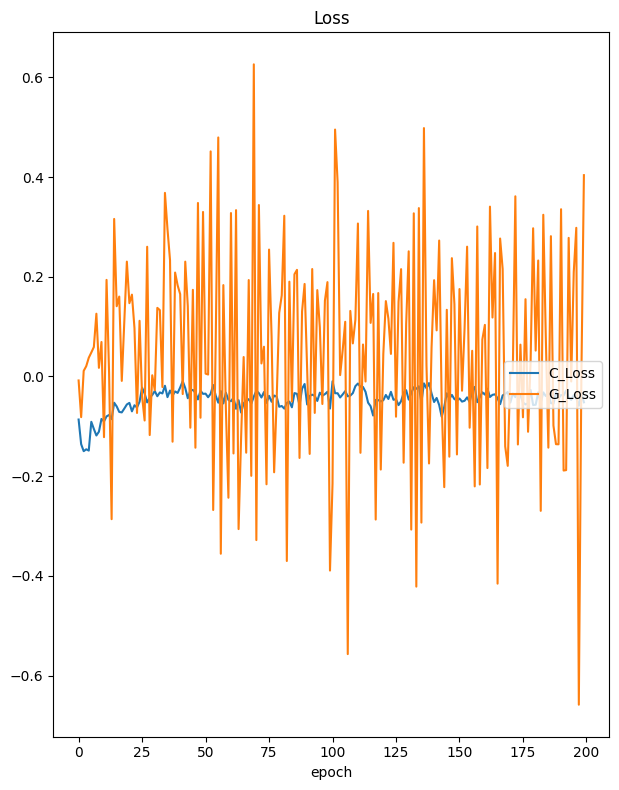

LOSS

C_Loss           	 (min:   -0.150, max:   -0.009, cur:   -0.052)

G_Loss           	 (min:   -0.659, max:    0.626, cur:    0.404)

WGAN looks to be a lot more unstable

**Let's try and implement another GAN.**

We are not updating the image size to be 64*64 and updating the transformer accordingly

In [5]:
# Defining another different transformer for our Images

transform=transforms.Compose([
            transforms.Resize(64), # Make smallest dimension 32
            transforms.CenterCrop(64), # Cut to square image
            transforms.Grayscale(), # Convert to grayscale
            transforms.ToTensor() # Transform from PIL image to Tensor
        ])

In [6]:
from torch.utils.data import Dataset, DataLoader

# Instantiate the dataset
train_dataset = CustomImageDataset(data_dir, transform)

# Check the total number of images
print(f"Total number of images: {len(train_dataset)}")

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

# Fetch a batch of images
images_batch = next(iter(train_loader))
print(f"Image batch shape: {images_batch.size()}")

Total number of images: 8000
Image batch shape: torch.Size([100, 1, 64, 64])


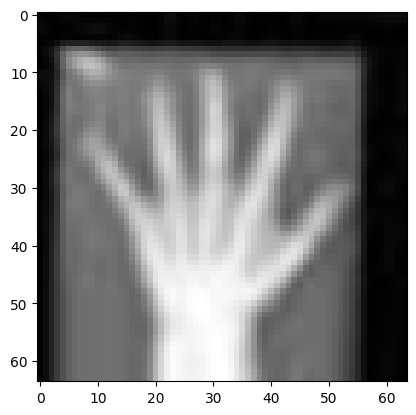

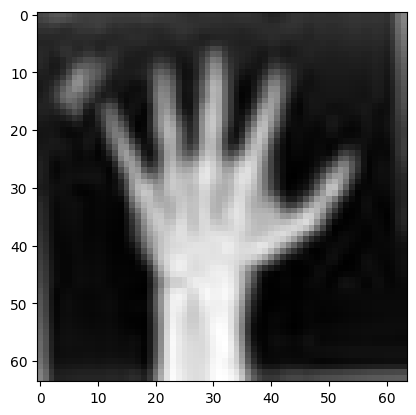

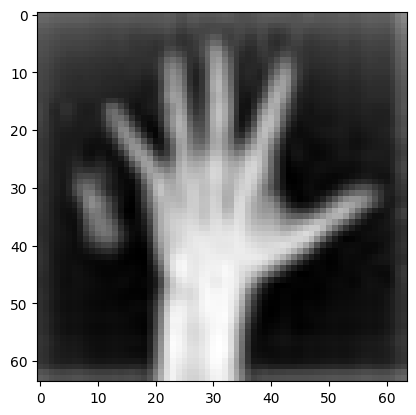

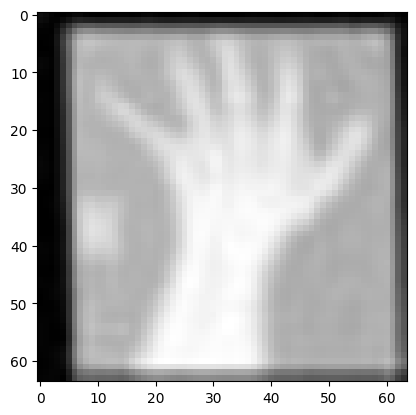

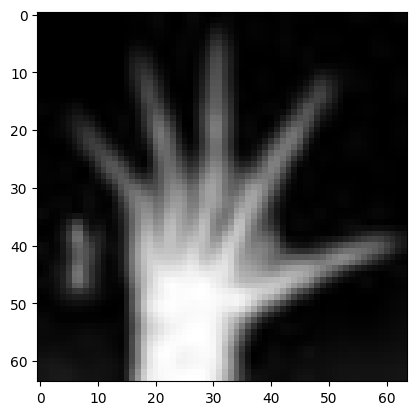

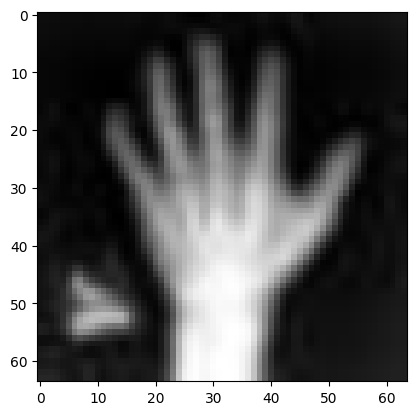

In [ ]:
import matplotlib.pyplot as plt

# Function to display an image
def show_image(img):
    # Handle case for single-channel and multi-channel images differently
    if img.shape[0] == 1:  # Grayscale image (1 channel)
        plt.imshow(img.squeeze(), cmap='gray')
    else:  # RGB image (3 channels)
        # Convert from PyTorch's channel-first format to channel-last format
        img = img.permute(1, 2, 0)
        plt.imshow(img)
    plt.show()

# Display the first image from the first 9 batches
for i, images in enumerate(train_loader):
    if i == 6:  # Stop after 9 images
        break
    show_image(images[0])  # Adjust [0] to select different images in the batch


creating a more complex generator and discriminator.

In [7]:
# All networks should inherit `nn.Module`
class Generator(nn.Module):
    """
    Takes a 100 element input vector and transforms
    it into an image with dimensions 64x64

    input is bacth_size x n_ch x width x height.
    In this case, (batch_size, 100, 1, 1)
    """

    # Note on convolutional transpose operations:
    # Input: (batch, chs_in, h_in, w_in)
    # Output: (batch, chs_out, h_out, w_out)
    # h_out = (h_in-1) * stride - 2 * padding + kernel

    # Anything with optimizable parameters needs to be
    # setup within the init method
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(

            # Hidden Layer 1
            nn.ConvTranspose2d(in_channels=100,
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),

            # Hidden Layer 2
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),

            # Hidden Layer 3
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),

            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),

            # Output Layer
            nn.ConvTranspose2d(in_channels=64,
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )

    # All modules must override `forward`
    def forward(self, x):
        x = self.main(x)
        return x

In [8]:
class Discriminator(nn.Module):
    """
    Takes in a 32x32 image and produces a decision
    about if that image is genuine or generated.

    Input is (bacth_size x n_ch x width x height)
    In this case (100, 1, 64, 64)
    """

    def __init__(self):
        super(Discriminator, self).__init__()

        # input is 1ch x 64w x 64h
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.main = nn.Sequential(

            # (batch_size, 1, 64, 64)
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),

            # (batch_size, 64, 32, 32)
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2),

            # (batch_size, 128, 16, 16)
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2),

            # (batch_size, 256, 8, 8)
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(negative_slope=0.2),

            # (batch_size, 512, 4, 4)
            nn.Conv2d(in_channels=512,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),

            # (batch_size, 1, 1, 1)
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.main(x)
        return x

In [9]:
G = Generator()
G(torch.randn(12, 100, 1, 1)).shape

torch.Size([12, 1, 64, 64])

In [10]:
# Confirm the discriminator produces a ruling given an image
# Map from (batch, 1, 64, 64) to (batch, 1, 1, 1)
D = Discriminator()
D(torch.randn(14, 1, 64, 64)).shape

torch.Size([14, 1, 1, 1])

In [11]:
# Choose a loss function. Binary Cross Entropy Loss.
compute_loss = nn.BCELoss()

# Specify training details
n_epochs = 100
batch_size = 100
z_dim = 100

In [12]:
# Move everything to the GPU for training
gpu = torch.device(0)
G = G.to(gpu)
D = D.to(gpu)

In [13]:

# Create an optimizer to update the weights of each network
optimizer_d = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

test_noise = torch.randn((8, 100, 1, 1)).to(gpu)

In [14]:
def D_train(x):
    # Reset gradients
    D.zero_grad()

    # Train with real data
    real_data = Variable(x).to(gpu)
    real_labels = Variable(torch.ones(real_data.size(0), 1, 1, 1)).to(gpu)
    real_output = D(real_data)
    d_loss_real = compute_loss(real_output, real_labels)

    # Train with fake data
    noise = Variable(torch.randn(real_data.size(0), 100, 1, 1)).to(gpu)
    fake_data = G(noise)
    fake_labels = Variable(torch.zeros(real_data.size(0), 1, 1, 1)).to(gpu)
    fake_output = D(fake_data.detach())
    d_loss_fake = compute_loss(fake_output, fake_labels)

    # Backpropagation
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_d.step()

    return d_loss.item()


In [15]:
def G_train(x):
    # Reset gradients
    G.zero_grad()

    # Generate fake data
    noise = Variable(torch.randn(x.size(0), 100, 1, 1)).to(gpu)
    fake_data = G(noise)

    # Train with fake data
    labels = Variable(torch.ones(x.size(0), 1, 1, 1)).to(gpu)
    output = D(fake_data)
    g_loss = compute_loss(output, labels)

    # Backpropagation
    g_loss.backward()
    optimizer_g.step()

    return g_loss.item()

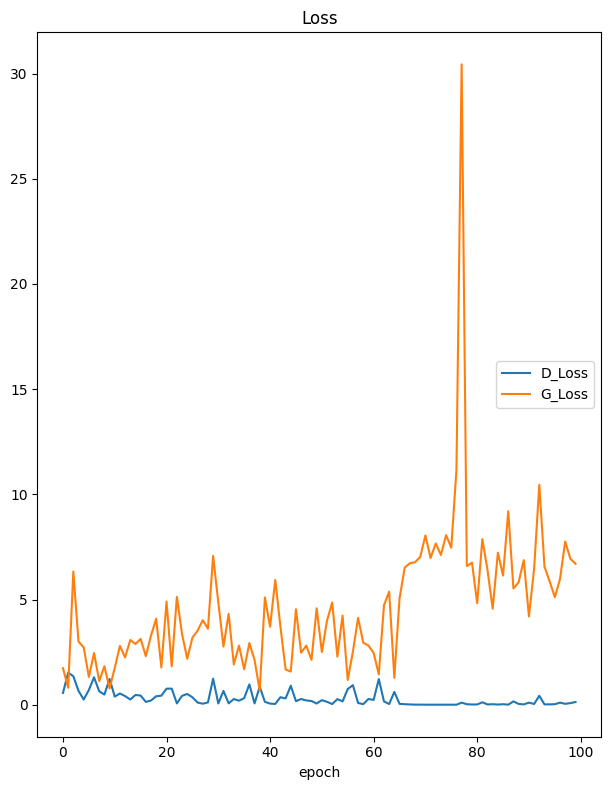

Loss
	D_Loss           	 (min:    0.000, max:    1.529, cur:    0.128)
	G_Loss           	 (min:    0.673, max:   30.437, cur:    6.698)
Epoch 100/100, D Loss: 0.3144242472248152, G Loss: 5.563626687973738


In [ ]:
import numpy as np

groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epochs+1):
    D_losses, G_losses = [], []
    logs = {}
    for i, x in enumerate(train_loader):
        D_loss = D_train(x)
        G_loss = G_train(x)
        logs['D_Loss'] = D_loss
        logs['G_Loss'] = G_loss
        D_losses.append(D_loss)
        G_losses.append(G_loss)

    liveloss.update(logs)
    liveloss.draw()

    # Save model every 20 epochs
    if epoch % 20 == 0:
        torch.save(G.state_dict(), f"/content/gdrive/MyDrive/GAN_epoch_{epoch}.pth")

    print(f"Epoch {epoch}/{n_epochs}, D Loss: {np.mean(D_losses)}, G Loss: {np.mean(G_losses)}")


This looks like that the Discriminator is overpowering our Generator

We have a generator and discriminator model for Gan, the problem with our model is that the generators loss is increasing over time and the discriminator loss is tending to 0.

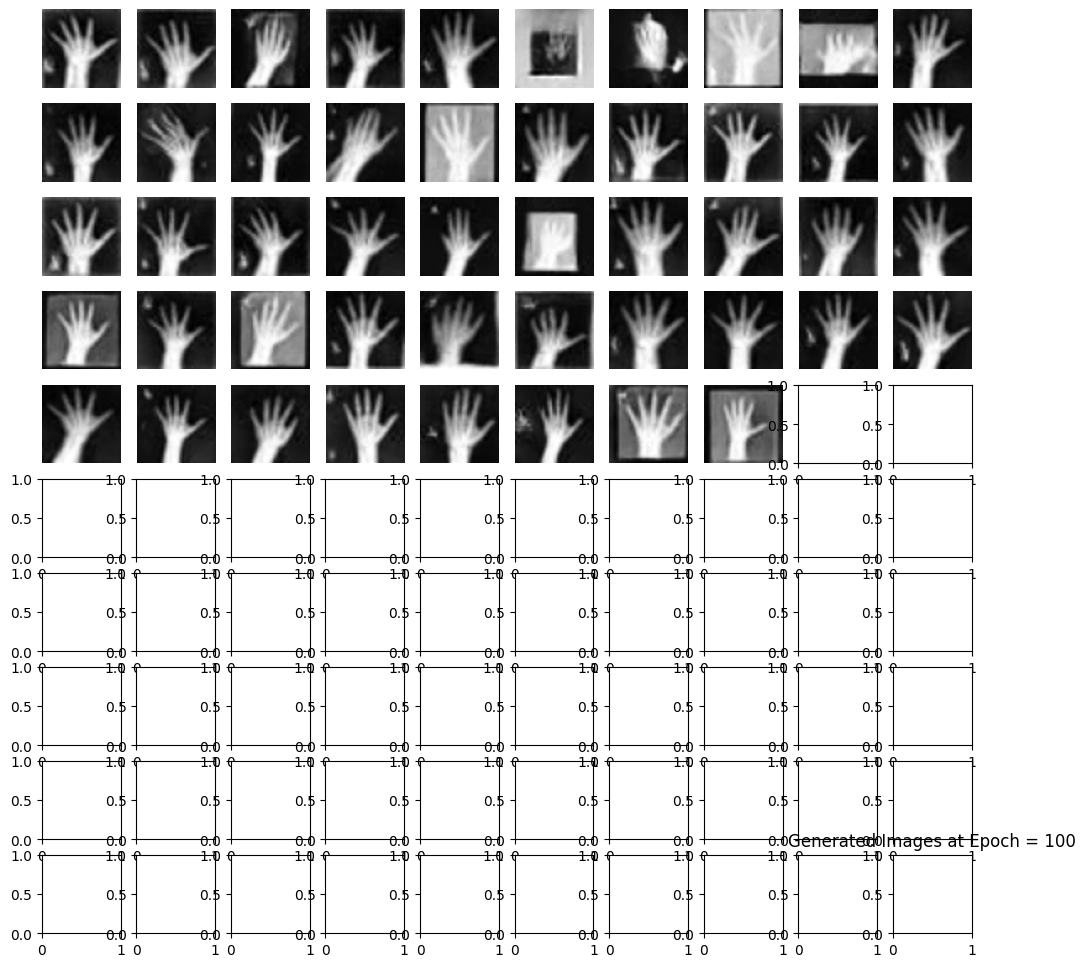

In [286]:
# from torchvision.utils import save_image
set_seed(42)

epoch = 100  # Model after 80 epochs
# Assuming G is defined and has the same architecture as during training
G.load_state_dict(torch.load(f"/content/gdrive/MyDrive/GAN_epoch_{epoch}.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G.to(device)

batch_size = 100  # Set to your desired batch size
z_dim = 100       # Set to your generator's noise dimension

with torch.no_grad():
    test_z = torch.randn(48, 100, 1, 1).to(device)
    generated = G(test_z)

    # Optionally save the generated images
    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample.png')

fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 64, 64).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')
plt.title(f'Generated Images at Epoch = {epoch:03d}')
plt.show()

In [ ]:
class Discriminator(nn.Module):
    """
    A discriminator network with an additional convolution layer.
    Takes in a 64x64 image and produces a decision
    about whether that image is genuine or generated.
    Input is (batch_size x n_ch x width x height), in this case (batch, 1, 64, 64).
    Outputs (batch_size, 1, 1, 1) after flattening.
    """

    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),  # Output: (64 x 32 x 32)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),  # Output: (128 x 16 x 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1), # Output: (256 x 8 x 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d(1)  # Adaptive pooling to get (256 x 1 x 1)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(256, 512),  # Process the 256 channels
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output to (batch_size, 256)
        x = self.linear_layers(x)
        return x.view(-1, 1, 1, 1)  # Reshape to (batch_size, 1, 1, 1)


Modify the Generator to perform better. Changes are mentioned in the comments. We have added more layers and made our Generator more complex

In [41]:
class Generator(nn.Module):
    """
    Improved generator network.
    Takes a 100 element input vector and transforms
    it into an image with dimensions 64x64.
    Input is (batch_size, 100, 1, 1).
    """

    def __init__(self):
        super(Generator, self).__init__()

        # Increasing the capacity of the Generator
        # by adding more features to each layer
        self.main = nn.Sequential(
            # Hidden Layer 1
            nn.ConvTranspose2d(in_channels=100,
                               out_channels=1024,  # Increased from 512 to 1024
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),

            # Hidden Layer 2
            nn.ConvTranspose2d(in_channels=1024,  # Adjusted to match previous layer
                               out_channels=512,  # Increased from 256 to 512
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),

            # Hidden Layer 3
            nn.ConvTranspose2d(in_channels=512,  # Adjusted to match previous layer
                               out_channels=256,  # Increased from 128 to 256
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),

            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=256,  # Adjusted to match previous layer
                               out_channels=128,  # Increased from 64 to 128
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(True),

            # Output Layer
            nn.ConvTranspose2d(in_channels=128,  # Adjusted to match previous layer
                               out_channels=1,   # Output channels = 1 for grayscale image
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()  # Tanh activation for output
        )

    def forward(self, x):
        x = self.main(x)
        return x


In [42]:
G = Generator()
G(torch.randn(12, 100, 1, 1)).shape

torch.Size([12, 1, 64, 64])

In [43]:
# Map from (batch, 1, 64, 64) to (batch, 1, 1, 1)
D = Discriminator()
D(torch.randn(14, 1, 64, 64)).shape

torch.Size([14, 1, 1, 1])

In [44]:
# Choose a loss function. Binary Cross Entropy Loss.
compute_loss = nn.BCELoss()

# Specify training details
n_epochs = 100
batch_size = 100
z_dim = 100

# Move everything to the GPU for training
gpu = torch.device(0)
G = G.to(gpu)
D = D.to(gpu)

Reducing the learning rate of Discriminator so that it don't overpower our Generator

In [46]:

# Create an optimizer to update the weights of each network

optimizer_d = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

test_noise = torch.randn((8, 100, 1, 1)).to(gpu)


In [19]:
def D_train(x):
    # Reset gradients
    D.zero_grad()

    # Train with real data
    real_data = Variable(x).to(gpu)
    real_labels = Variable(torch.ones(real_data.size(0), 1, 1, 1)).to(gpu)
    real_output = D(real_data)
    d_loss_real = compute_loss(real_output, real_labels)

    # Train with fake data
    noise = Variable(torch.randn(real_data.size(0), 100, 1, 1)).to(gpu)
    fake_data = G(noise)
    fake_labels = Variable(torch.zeros(real_data.size(0), 1, 1, 1)).to(gpu)
    fake_output = D(fake_data.detach())
    d_loss_fake = compute_loss(fake_output, fake_labels)

    # Backpropagation
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_d.step()

    return d_loss.item()


In [20]:
def G_train(x):
    # Reset gradients
    G.zero_grad()

    # Generate fake data
    noise = Variable(torch.randn(x.size(0), 100, 1, 1)).to(gpu)
    fake_data = G(noise)

    # Train with fake data
    labels = Variable(torch.ones(x.size(0), 1, 1, 1)).to(gpu)
    output = D(fake_data)
    g_loss = compute_loss(output, labels)

    # Backpropagation
    g_loss.backward()
    optimizer_g.step()

    return g_loss.item()

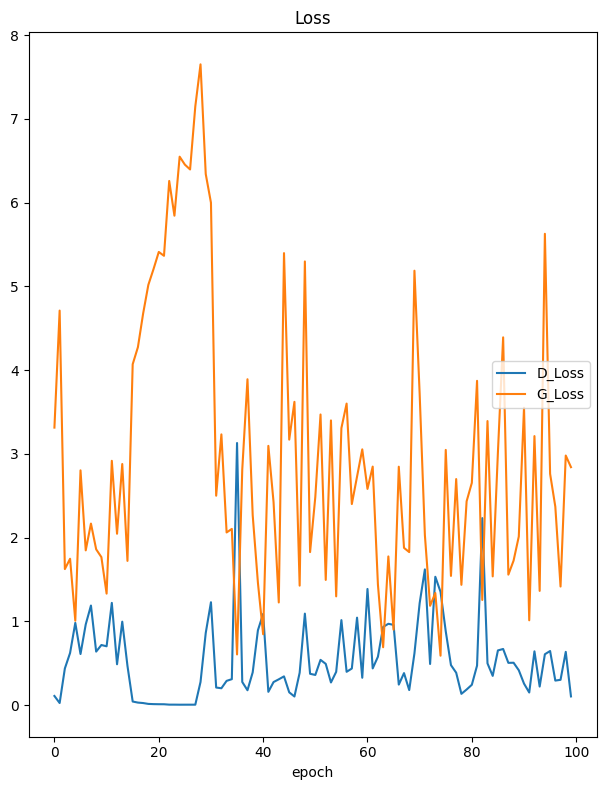

Loss
	D_Loss           	 (min:    0.004, max:    3.129, cur:    0.102)
	G_Loss           	 (min:    0.589, max:    7.651, cur:    2.840)
Epoch 100/100, D Loss: 0.6795576472766698, G Loss: 2.6409175634384154


In [21]:
import numpy as np

groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epochs+1):
    D_losses, G_losses = [], []
    logs = {}
    for i, x in enumerate(train_loader):
        D_loss = D_train(x)
        G_loss = G_train(x)
        logs['D_Loss'] = D_loss
        logs['G_Loss'] = G_loss
        D_losses.append(D_loss)
        G_losses.append(G_loss)

    liveloss.update(logs)
    liveloss.draw()

    # Save model every 20 epochs
    if epoch % 10 == 0:
        torch.save(G.state_dict(), f"/content/gdrive/MyDrive/my_GAN_{epoch}.pth")

    print(f"Epoch {epoch}/{n_epochs}, D Loss: {np.mean(D_losses)}, G Loss: {np.mean(G_losses)}")


Let's try our model increasing the number of epochs

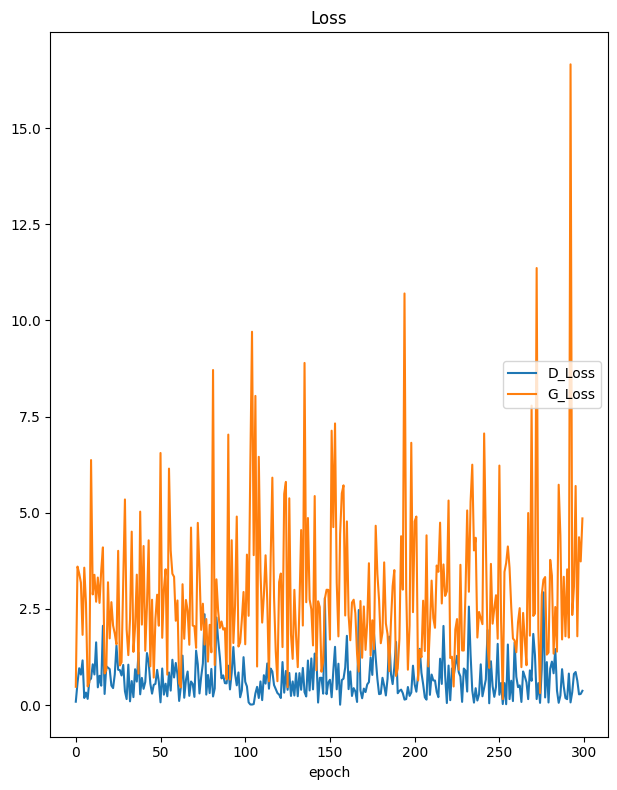

Loss
	D_Loss           	 (min:    0.008, max:    2.930, cur:    0.369)
	G_Loss           	 (min:    0.153, max:   16.657, cur:    4.852)
Epoch 300/300, D Loss: 0.5035349503159523, G Loss: 3.928068442642689


In [24]:
import numpy as np

n_epochs = 300
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epochs+1):
    D_losses, G_losses = [], []
    logs = {}
    for i, x in enumerate(train_loader):
        D_loss = D_train(x)
        G_loss = G_train(x)
        logs['D_Loss'] = D_loss
        logs['G_Loss'] = G_loss
        D_losses.append(D_loss)
        G_losses.append(G_loss)

    liveloss.update(logs)
    liveloss.draw()

    epoch_D_loss = np.mean(D_losses)
    epoch_G_loss = np.mean(G_losses)
    print(f"Epoch {epoch}/{n_epochs}, D Loss: {epoch_D_loss}, G Loss: {epoch_G_loss}")

    # Save model if G_loss is less than D_loss
    if epoch_G_loss < epoch_D_loss:
        torch.save(G.state_dict(), f"/content/gdrive/MyDrive/my_GAN_{epoch}.pth")

    # Save model every 20 epochs
    if epoch % 30 == 0:
        torch.save(G.state_dict(), f"/content/gdrive/MyDrive/final_GAN_epoch_{epoch}.pth")

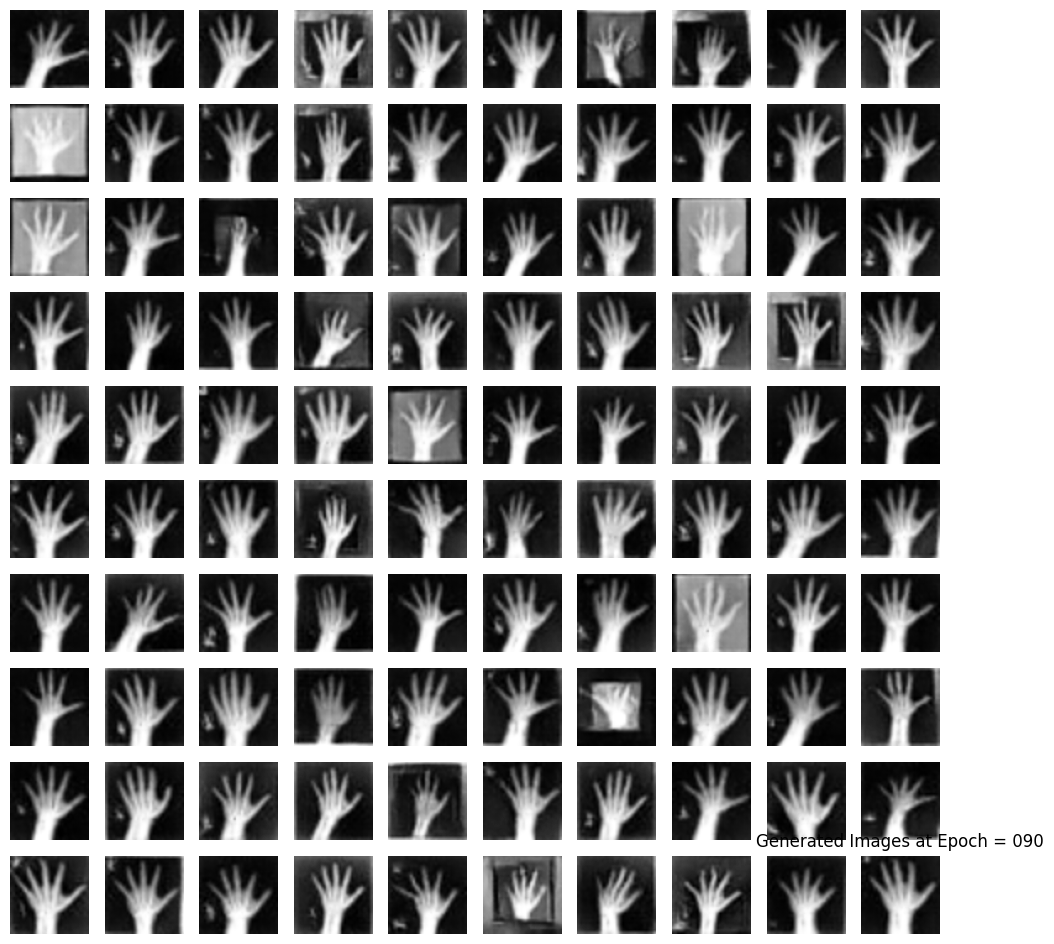

In [49]:
# from torchvision.utils import save_image
set_seed(42)

G = Generator()
epoch = 90  # Model after 80 epochs
# Assuming G is defined and has the same architecture as during training
G.load_state_dict(torch.load(f"/content/gdrive/MyDrive/final_GAN_epoch_90.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G.to(device)

batch_size = 100  # Set to your desired batch size
z_dim = 100       # Set to your generator's noise dimension

with torch.no_grad():
    test_z = torch.randn(100, 100, 1, 1).to(device)
    generated = G(test_z)

    # Optionally save the generated images
    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample.png')

fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 64, 64).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')
plt.title(f'Generated Images at Epoch = {epoch:03d}')
plt.show()

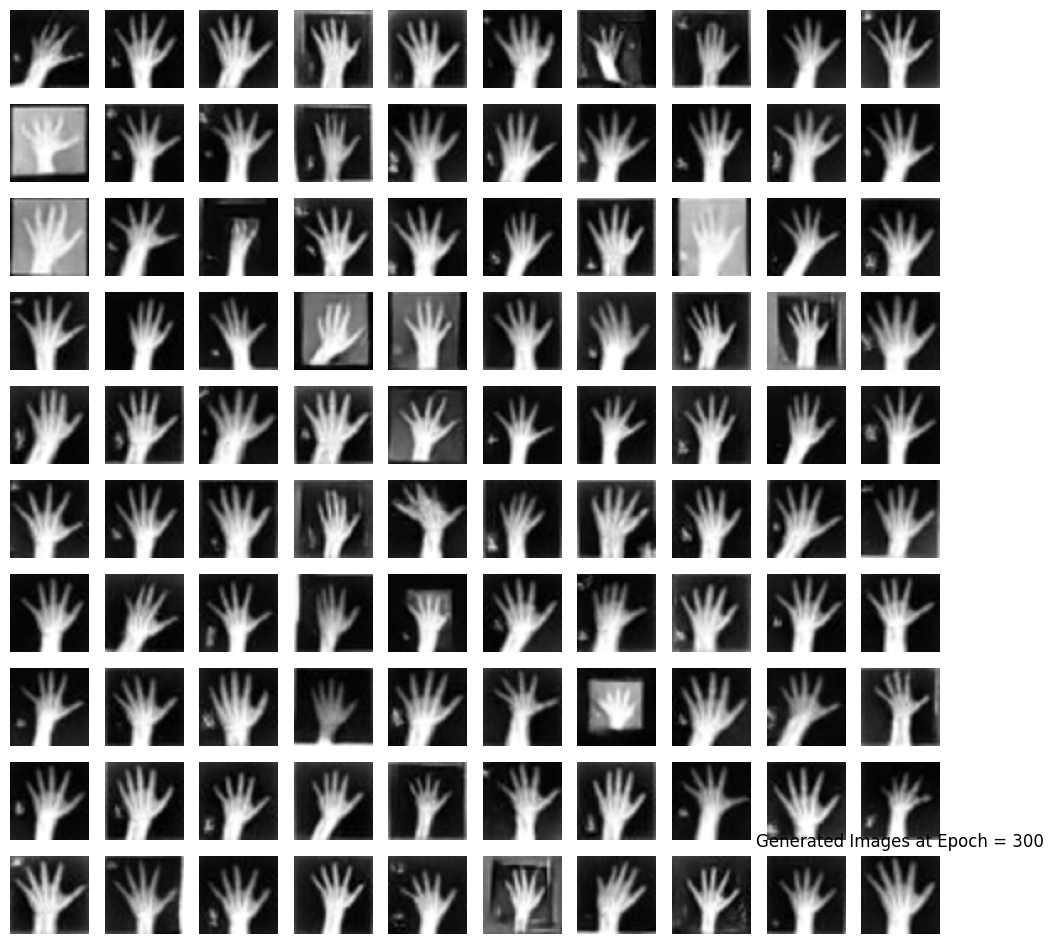

In [50]:
# from torchvision.utils import save_image
set_seed(42)

G = Generator()
epoch = 300  # Model after 80 epochs
# Assuming G is defined and has the same architecture as during training
G.load_state_dict(torch.load(f"/content/gdrive/MyDrive/final_GAN_epoch_300.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G.to(device)

batch_size = 100  # Set to your desired batch size
z_dim = 100       # Set to your generator's noise dimension

with torch.no_grad():
    test_z = torch.randn(100, 100, 1, 1).to(device)
    generated = G(test_z)

    # Optionally save the generated images
    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample.png')

fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 64, 64).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')
plt.title(f'Generated Images at Epoch = {epoch:03d}')
plt.show()

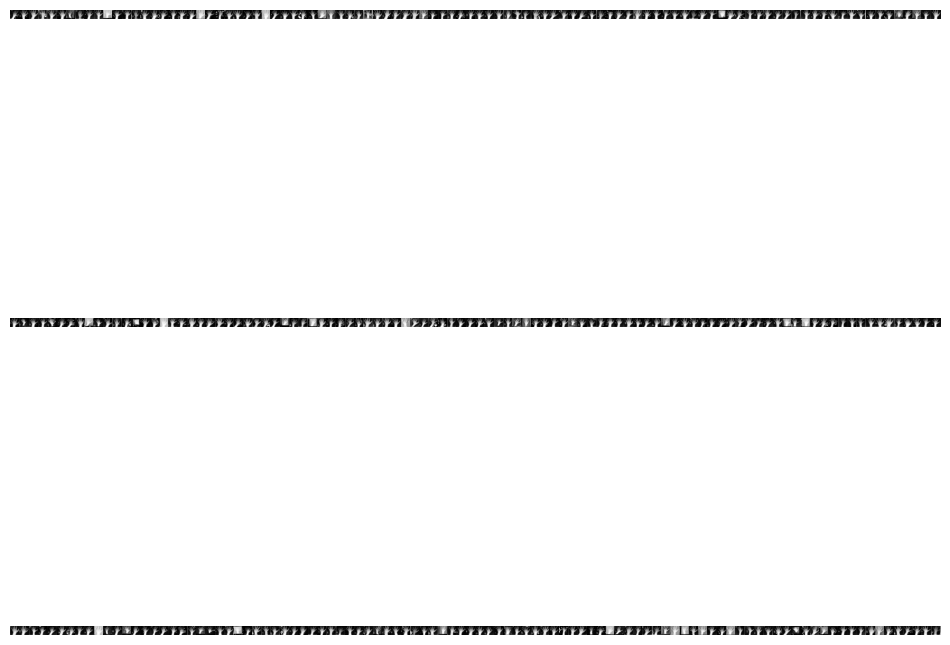

In [65]:
import os
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torchvision import transforms

# Set your seed for reproducibility
set_seed(42)

# Load the Generator
G = Generator()
epoch = 270  # Model after 100 epochs
G.load_state_dict(torch.load(f"/content/gdrive/MyDrive/final_GAN_epoch_270.pth"))
G.to(device)

# Directory where the images will be saved
save_dir = "/content/gdrive/MyDrive/GAN_hands"
os.makedirs(save_dir, exist_ok=True)

# Generate images
batch_size = 100  # Set to your desired batch size
z_dim = 100      # Set to your generator's noise dimension
n_batches = 3   # Calculate to generate 300 images in total

fig, axarr = plt.subplots(n_batches, batch_size, figsize=(12, 12))
for i in range(n_batches):
    with torch.no_grad():
        test_z = torch.randn(batch_size, z_dim, 1, 1).to(device)
        generated = G(test_z)
        generated = generated.view(generated.size(0), 1, 64, 64)  # Reshape if necessary

        for j, img in enumerate(generated):
            img_index = i * batch_size + j + 1

            # Save the image
            save_image(img, os.path.join(save_dir, f"gs1023_{img_index:03d}.jpeg"))

            # Display the image
            ax = axarr[i, j]
            img = transforms.ToPILImage()(img.cpu().squeeze(0))
            ax.imshow(img, cmap='gray')
            ax.axis('off')

            if img_index == 300:  # Stop if 300 images are generated
                break

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


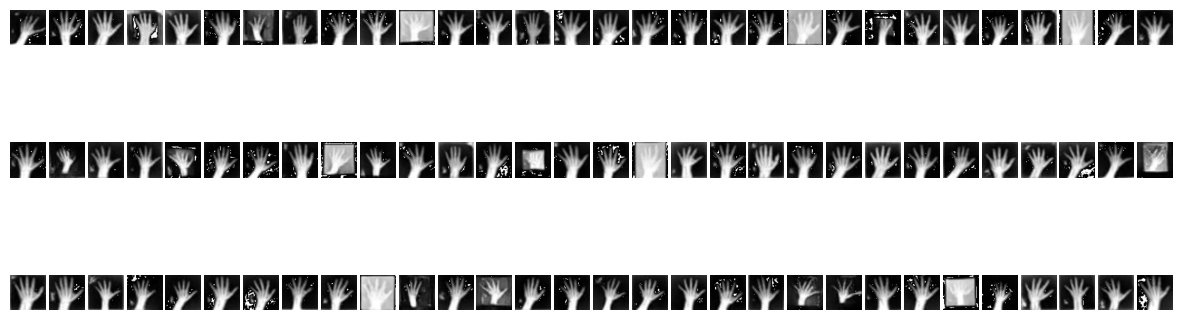

In [64]:
import os
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torchvision import transforms

# Set your seed for reproducibility
set_seed(42)

# Load the Generator
G = Generator()
epoch = 270  # Model after 270 epochs
G.load_state_dict(torch.load(f"/content/gdrive/MyDrive/final_GAN_epoch_270.pth"))
G.to(device)

# Directory where the images will be saved
save_dir = "/content/gdrive/MyDrive/GAN_hands"
os.makedirs(save_dir, exist_ok=True)

# Generate images
batch_size = 100  # Set to your desired batch size
z_dim = 100       # Set to your generator's noise dimension
n_batches = 3     # Calculate to generate 300 images in total

# Setting up the plot
fig, axarr = plt.subplots(n_batches, 30, figsize=(15, 5))  # Changed to 30 images per row
for i in range(n_batches):
    with torch.no_grad():
        test_z = torch.randn(batch_size, z_dim, 1, 1).to(device)
        generated = G(test_z)
        generated = generated.view(generated.size(0), 1, 64, 64)  # Reshape if necessary

        for j, img in enumerate(generated):
            if j >= 30:  # Display only the first 30 images per batch
                break

            img_index = i * batch_size + j + 1

            # Save the image
            save_image(img, os.path.join(save_dir, f"gs1023_{img_index:03d}.jpeg"))

            # Display the image
            ax = axarr[i, j]
            img = transforms.ToPILImage()(img.cpu().squeeze(0))
            ax.imshow(img, cmap='gray')
            ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


Let's try some more hyperparameter tuning and update the network.

Changing the activation function in Generator and Discriminator

In [48]:
class Generator(nn.Module):
    """
    Improved generator network.
    Takes a 100 element input vector and transforms
    it into an image with dimensions 64x64.
    Input is (batch_size, 100, 1, 1).
    """

    def __init__(self):
        super(Generator, self).__init__()

        # Increasing the capacity of the Generator
        # by adding more features to each layer
        self.main = nn.Sequential(
            # Hidden Layer 1
            nn.ConvTranspose2d(in_channels=100,
                               out_channels=1024,  # Increased from 512 to 1024
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),

            # Hidden Layer 2
            nn.ConvTranspose2d(in_channels=1024,  # Adjusted to match previous layer
                               out_channels=512,  # Increased from 256 to 512
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),

            # Hidden Layer 3
            nn.ConvTranspose2d(in_channels=512,  # Adjusted to match previous layer
                               out_channels=256,  # Increased from 128 to 256
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),

            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=256,  # Adjusted to match previous layer
                               out_channels=128,  # Increased from 64 to 128
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(True),

            # Output Layer
            nn.ConvTranspose2d(in_channels=128,  # Adjusted to match previous layer
                               out_channels=1,   # Output channels = 1 for grayscale image
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()  # Tanh activation for output
        )

    def forward(self, x):
        x = self.main(x)
        return x


In [23]:
class Discriminator(nn.Module):
    """
    A discriminator network with an additional convolution layer.
    Takes in a 64x64 image and produces a decision
    about whether that image is genuine or generated.
    Input is (batch_size x n_ch x width x height), in this case (batch, 1, 64, 64).
    Outputs (batch_size, 1, 1, 1) after flattening.
    """

    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),  # Output: (64 x 32 x 32)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),  # Output: (128 x 16 x 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1), # Output: (256 x 8 x 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d(1)  # Adaptive pooling to get (256 x 1 x 1)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(256, 512),  # Process the 256 channels
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output to (batch_size, 256)
        x = self.linear_layers(x)
        return x.view(-1, 1, 1, 1)  # Reshape to (batch_size, 1, 1, 1)


In [24]:
G = Generator()
G(torch.randn(12, 100, 1, 1)).shape

torch.Size([12, 1, 64, 64])

In [25]:
# Confirm the discriminator produces a ruling given an image
# Map from (batch, 1, 64, 64) to (batch, 1, 1, 1)
D = Discriminator()
D(torch.randn(14, 1, 64, 64)).shape

torch.Size([14, 1, 1, 1])

In [26]:
# Move everything to the GPU for training
gpu = torch.device(0)
G = G.to(gpu)
D = D.to(gpu)

In [27]:
def D_train(x):
    # Reset gradients
    D.zero_grad()

    # Train with real data
    real_data = Variable(x).to(gpu)
    real_labels = Variable(torch.ones(real_data.size(0), 1, 1, 1)).to(gpu)
    real_output = D(real_data)
    d_loss_real = compute_loss(real_output, real_labels)

    # Train with fake data
    noise = Variable(torch.randn(real_data.size(0), 100, 1, 1)).to(gpu)
    fake_data = G(noise)
    fake_labels = Variable(torch.zeros(real_data.size(0), 1, 1, 1)).to(gpu)
    fake_output = D(fake_data.detach())
    d_loss_fake = compute_loss(fake_output, fake_labels)

    # Backpropagation
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_d.step()

    return d_loss.item()


In [28]:
def G_train(x):
    # Reset gradients
    G.zero_grad()

    # Generate fake data
    noise = Variable(torch.randn(x.size(0), 100, 1, 1)).to(gpu)
    fake_data = G(noise)

    # Train with fake data
    labels = Variable(torch.ones(x.size(0), 1, 1, 1)).to(gpu)
    output = D(fake_data)
    g_loss = compute_loss(output, labels)

    # Backpropagation
    g_loss.backward()
    optimizer_g.step()

    return g_loss.item()

In [29]:
from torch import optim

# Choose a loss function. Binary Cross Entropy Loss.
compute_loss = nn.BCELoss()

# Specify training details
n_epochs = 500
batch_size = 100
z_dim = 100


# Create an optimizer to update the weights of each network
optimizer_d = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

test_noise = torch.randn((8, 100, 1, 1)).to(gpu)


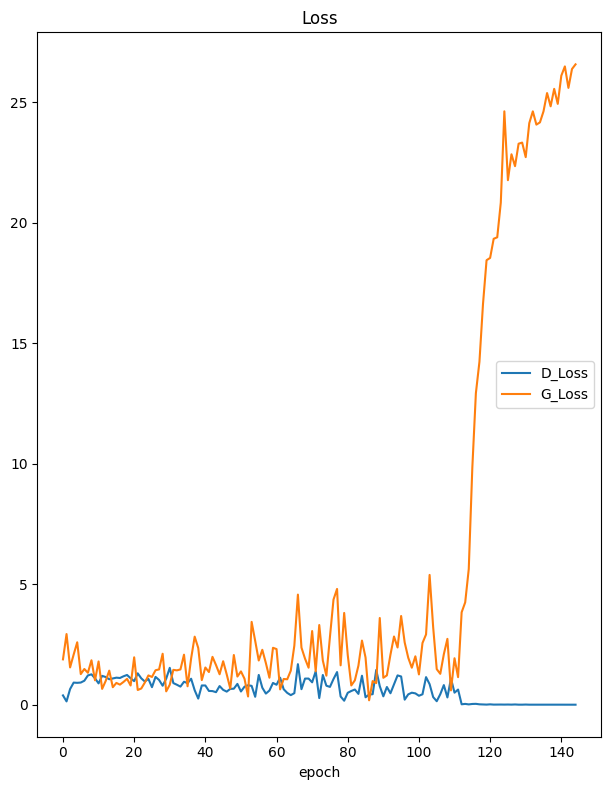

Loss
	D_Loss           	 (min:    0.000, max:    1.682, cur:    0.001)
	G_Loss           	 (min:    0.183, max:   26.567, cur:   26.567)
Epoch 145/500, D Loss: 0.001194429152928933, G Loss: 25.966372704505922


KeyboardInterrupt: ignored

In [34]:
import numpy as np

n_epochs = 500
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epochs+1):
    D_losses, G_losses = [], []
    logs = {}
    for i, x in enumerate(train_loader):
        D_loss = D_train(x)
        G_loss = G_train(x)
        logs['D_Loss'] = D_loss
        logs['G_Loss'] = G_loss
        D_losses.append(D_loss)
        G_losses.append(G_loss)

    liveloss.update(logs)
    liveloss.draw()

    epoch_D_loss = np.mean(D_losses)
    epoch_G_loss = np.mean(G_losses)
    print(f"Epoch {epoch}/{n_epochs}, D Loss: {epoch_D_loss}, G Loss: {epoch_G_loss}")

    # Save model if G_loss is less than D_loss
    if epoch_D_loss < epoch_G_loss:
        torch.save(G.state_dict(), f"/content/gdrive/MyDrive/final/my_GAN_{epoch}.pth")

    # Save model every 25 epochs
    if epoch % 25 == 0:
        torch.save(G.state_dict(), f"/content/gdrive/MyDrive/final/final_GAN_epoch_{epoch}.pth")

After 100 epochs, the discriminator is getting a bas result, this can be due to overfitting. Let's try some modifications for our generator.

Let's try and udpate the learning rate.

In [57]:
from torch import optim

# Choose a loss function. Binary Cross Entropy Loss.
compute_loss = nn.BCELoss()

# Specify training details
n_epochs = 250
batch_size = 100
z_dim = 100


# Create an optimizer to update the weights of each network
optimizer_d = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_g = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))

test_noise = torch.randn((8, 100, 1, 1)).to(gpu)


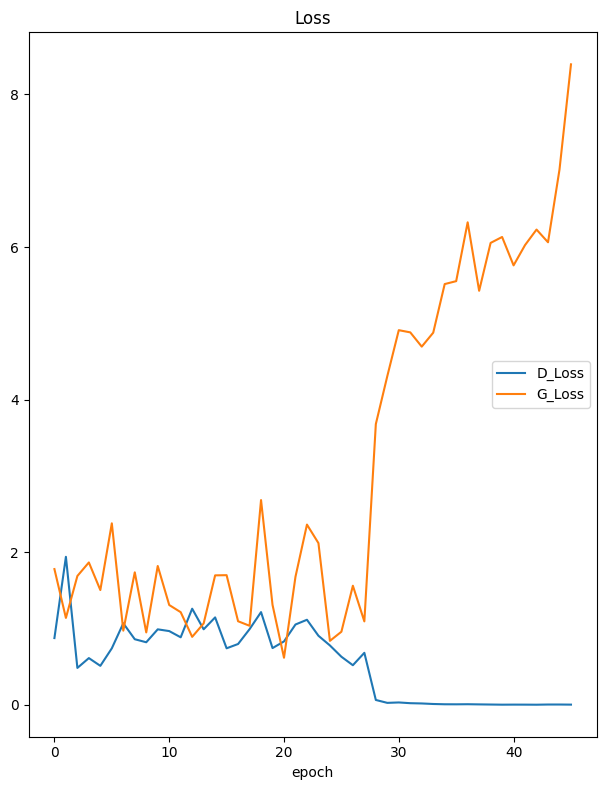

Loss
	D_Loss           	 (min:    0.004, max:    1.941, cur:    0.005)
	G_Loss           	 (min:    0.618, max:    8.393, cur:    8.393)
Epoch 46/250, D Loss: 0.006913719687145203, G Loss: 7.792807072401047


KeyboardInterrupt: ignored

In [58]:
import numpy as np

n_epochs = 250
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epochs+1):
    D_losses, G_losses = [], []
    logs = {}
    for i, x in enumerate(train_loader):
        D_loss = D_train(x)
        G_loss = G_train(x)
        logs['D_Loss'] = D_loss
        logs['G_Loss'] = G_loss
        D_losses.append(D_loss)
        G_losses.append(G_loss)

    liveloss.update(logs)
    liveloss.draw()

    epoch_D_loss = np.mean(D_losses)
    epoch_G_loss = np.mean(G_losses)
    print(f"Epoch {epoch}/{n_epochs}, D Loss: {epoch_D_loss}, G Loss: {epoch_G_loss}")

    # Save model if G_loss is less than D_loss
    if epoch_D_loss < epoch_G_loss:
        torch.save(G.state_dict(), f"/content/gdrive/MyDrive/final/upt_GAN_{epoch}.pth")

    # Save model every 25 epochs
    if epoch % 25 == 0:
        torch.save(G.state_dict(), f"/content/gdrive/MyDrive/final/upt_GAN_epoch_{epoch}.pth")

The Generator is dispurted after 30 epochs causing the loss to increase as we go along. Let's try some more modifications

Updating the learning rate again increasing the lr for generator and keeping the lr for discriminator same.

We are also modifying our Generator class to perform better

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    """
    Slightly modified Generator network.
    Takes a 100 element input vector and transforms it into an image with dimensions 64x64.
    Input is (batch_size, 100, 1, 1).
    """

    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Hidden Layer 1: Moderately reduced number of features
            nn.ConvTranspose2d(in_channels=100, out_channels=768, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=768),
            nn.ReLU(True),

            # Hidden Layer 2: Adjusted number of features
            nn.ConvTranspose2d(in_channels=768, out_channels=384, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=384),
            nn.ReLU(True),

            # Hidden Layer 3: Further adjusted number of features
            nn.ConvTranspose2d(in_channels=384, out_channels=192, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(True),

            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=192, out_channels=96, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(True),

            # Output Layer: Producing a single-channel (grayscale) image
            nn.ConvTranspose2d(in_channels=96, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Example of instantiating the generator
G = Generator()
G = G.to(gpu)


In [34]:
from torch import optim

# Choose a loss function. Binary Cross Entropy Loss.
compute_loss = nn.BCELoss()

# Specify training details
n_epochs = 250
batch_size = 100
z_dim = 100


# Create an optimizer to update the weights of each network
optimizer_d = optim.Adam(D.parameters(), lr=0.00015, betas=(0.5, 0.999))
optimizer_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

test_noise = torch.randn((8, 100, 1, 1)).to(gpu)


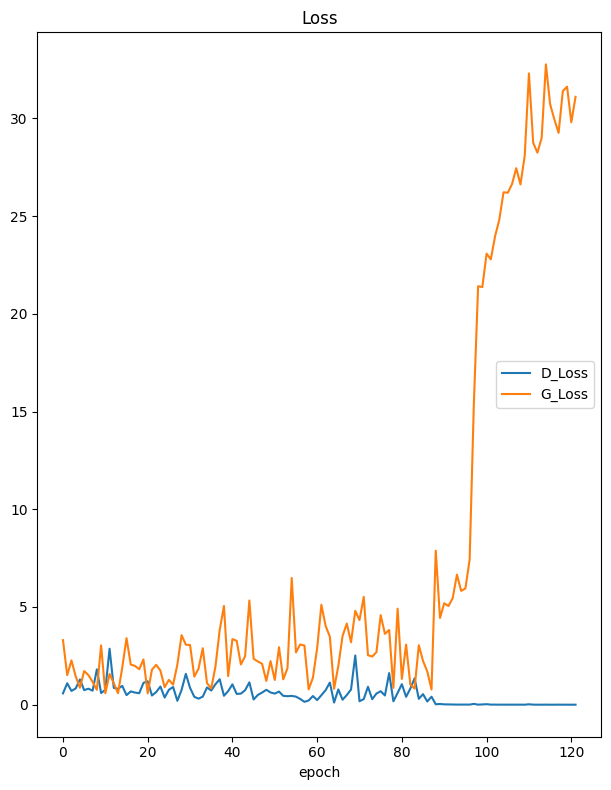

Loss
	D_Loss           	 (min:    0.000, max:    2.865, cur:    0.000)
	G_Loss           	 (min:    0.580, max:   32.767, cur:   31.105)
Epoch 122/300, D Loss: 0.0014394429359526838, G Loss: 30.560759592056275


In [ ]:
import numpy as np

n_epochs = 300
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epochs+1):
    D_losses, G_losses = [], []
    logs = {}
    for i, x in enumerate(train_loader):
        D_loss = D_train(x)
        G_loss = G_train(x)
        logs['D_Loss'] = D_loss
        logs['G_Loss'] = G_loss
        D_losses.append(D_loss)
        G_losses.append(G_loss)

    liveloss.update(logs)
    liveloss.draw()

    epoch_D_loss = np.mean(D_losses)
    epoch_G_loss = np.mean(G_losses)
    print(f"Epoch {epoch}/{n_epochs}, D Loss: {epoch_D_loss}, G Loss: {epoch_G_loss}")


    # Save model every 25 epochs
    if epoch % 25 == 0:
        torch.save(G.state_dict(), f"/content/gdrive/MyDrive/final/upt_GAN_epoch_{epoch}.pth")